In [1]:
pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 123.8 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is in

In [2]:
!wget https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
!unzip -q -o 'Ham10000_torch.zip'

--2025-12-15 22:27:58--  https://github.com/pvateekul/digitalhealth-ai2025/raw/main/dataset/Ham10000_torch.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip [following]
--2025-12-15 22:27:58--  https://media.githubusercontent.com/media/pvateekul/digitalhealth-ai2025/main/dataset/Ham10000_torch.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94841947 (90M) [application/zip]
Saving to: ‘Ham10000_torch.zip’

Ham10000_torch.zip  100%[===================>]  90.45M   210MB/s    in 0.4s    

2025-12-15 22:27:59 (210 MB

In [3]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

In [4]:
from keras.layers import DepthwiseConv2D

class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop("groups", None)
        super().__init__(*args, **kwargs)

In [6]:
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

from keras.models import load_model

model = load_model(
    "/content/keras_model.h5",
    custom_objects={"DepthwiseConv2D": FixedDepthwiseConv2D},
    compile=False
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
import os, random, numpy as np, pandas as pd, tensorflow as tf

In [41]:
df=pd.read_csv('GroundTruth.csv')
df['image']=df['image'].apply(lambda x: "images/"+x+ '.jpg')
df = df.drop(columns=["Unnamed: 0"])

lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['category'] = pd.Categorical(df['label']).codes
df['category'] = df['category'].astype(str)
print(df)

                       image                          label category
0    images/ISIC_0024310.jpg                       Melanoma        5
1    images/ISIC_0024306.jpg               Melanocytic nevi        4
2    images/ISIC_0024331.jpg           Basal cell carcinoma        1
3    images/ISIC_0024329.jpg              Actinic keratoses        0
4    images/ISIC_0024312.jpg  Benign keratosis like lesions        2
..                       ...                            ...      ...
345  images/ISIC_0025285.jpg           Basal cell carcinoma        1
346  images/ISIC_0025712.jpg              Actinic keratoses        0
347  images/ISIC_0024760.jpg  Benign keratosis like lesions        2
348  images/ISIC_0028926.jpg                 Dermatofibroma        3
349  images/ISIC_0027672.jpg               Vascular lesions        6

[350 rows x 3 columns]


In [42]:
train_df, val_df, test_df = df[:210], df[210:280], df[280:350]

print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Data Len Train: 210 Val: 70 Test: 70


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='category',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

print(f"Total number of samples in test set: {test_generator.samples}")
print(f"Class indices: {test_generator.class_indices}")

Found 70 validated image filenames belonging to 7 classes.
Total number of samples in test set: 70
Class indices: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [53]:
# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

report = classification_report(true_classes, predicted_classes, target_names=class_names, digits = 4)
M = confusion_matrix(true_classes, predicted_classes)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_names)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step
              precision    recall  f1-score   support

         MEL       0.00      0.00      0.00        10
          NV       0.00      0.00      0.00        10
         BCC       0.12      0.70      0.21        10
       AKIEC       0.00      0.00      0.00        10
         BKL       0.00      0.00      0.00        10
          DF       0.00      0.00      0.00        10
        VASC       0.00      0.00      0.00        10

    accuracy                           0.10        70
   macro avg       0.02      0.10      0.03        70
weighted avg       0.02      0.10      0.03        70

              precision    recall  f1-score   support

         MEL     0.0000    0.0000    0.0000        10
          NV     0.0000    0.0000    0.0000        10
         BCC     0.1207    0.7000    0.2059        10
       AKIEC     0.0000    0.0000    0.0000        10
         BKL     0.0000    0.0000    0.0000        10
          DF     0.0000    0.0000    0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

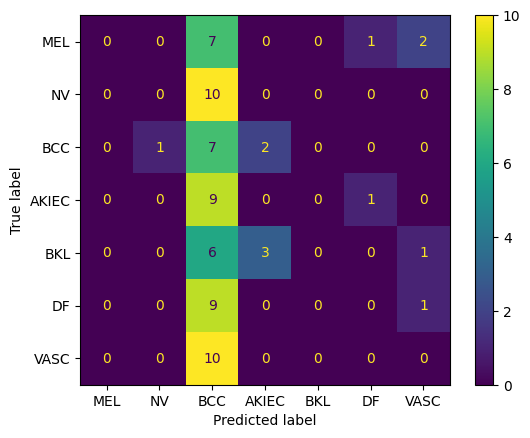

In [54]:
disp.plot()
plt.show()